<a href="https://colab.research.google.com/github/matdcp/Unsupervised-Fraud-detection-on-bank-transactions/blob/main/Pythonscript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42621 sha256=5866e89ab2bc8aadd3f1f9f4db6333482bae31e55b1c12e515ba5fa442fef598
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


In [5]:
# 1. Importazione delle librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.spatial.distance import pdist, squareform, mahalanobis
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import warnings
warnings.filterwarnings('ignore')


In [12]:
# 2. Caricamento dati e preparazione
# Assicurati di avere il file "bank_transactions_data_2.csv" nella cartella di lavoro
bank = pd.read_csv('/bank_transactions_data_2.csv')

# Conversione delle date (lasciamo che Pandas inferisca il formato, in modo da gestire date con orario)
bank['TransactionDate'] = pd.to_datetime(bank['TransactionDate'])
bank['PreviousTransactionDate'] = pd.to_datetime(bank['PreviousTransactionDate'])

# Ordinamento per AccountID e TransactionDate e calcolo della data precedente per ciascun account
bank = bank.sort_values(['AccountID', 'TransactionDate'])
bank['PreviousTransactionDate'] = bank.groupby('AccountID')['TransactionDate'].shift(1)

# Calcolo della distanza temporale (in giorni) tra transazioni
bank['DaysSinceLastTransaction'] = (bank['TransactionDate'] - bank['PreviousTransactionDate']).dt.days

# Rimuoviamo le righe con valori mancanti in DaysSinceLastTransaction
bank = bank.dropna(subset=['DaysSinceLastTransaction'])

# Feature Engineering: rapporto tra importo transazione e saldo (aggiungiamo 1 per evitare divisione per 0)
bank['TransactionRatio'] = bank['TransactionAmount'] / (bank['AccountBalance'] + 1)

# Identificazione del cambio dispositivo e IP (per ogni account, confronto con la riga precedente)
bank['DeviceChange'] = bank.groupby('AccountID')['DeviceID'].transform(lambda x: (x != x.shift(1)).astype(int))
bank['IPChange'] = bank.groupby('AccountID')['IP Address'].transform(lambda x: (x != x.shift(1)).astype(int))

# Flag per login anomali: più di 3 tentativi
bank['LoginAnomaly'] = (bank['LoginAttempts'] > 3).astype(int)

# Verifica valori negativi e NA
negative_values = (bank['DaysSinceLastTransaction'] < 0).sum()
missing_values = bank['DaysSinceLastTransaction'].isna().sum()

print("Numero di valori negativi:", negative_values)
print("Numero di valori NA:", missing_values)

# Esplorazione: summary e prime righe
print(bank['DaysSinceLastTransaction'].describe())
print(bank.head(10))

bank['DeviceChange'] = bank.groupby('AccountID')['DeviceID'].transform(lambda x: (x != x.shift(1)).astype(int))
bank['IPChange'] = bank.groupby('AccountID')['IP Address'].transform(lambda x: (x != x.shift(1)).astype(int))


print("Tabella DeviceChange:")
print(bank['DeviceChange'].value_counts())
print("Tabella IPChange:")
print(bank['IPChange'].value_counts())


Numero di valori negativi: 0
Numero di valori NA: 0
count    2017.000000
mean       54.106098
std        51.827731
min         0.000000
25%        15.000000
50%        39.000000
75%        76.000000
max       313.000000
Name: DaysSinceLastTransaction, dtype: float64
     TransactionID AccountID  TransactionAmount     TransactionDate  \
2016      TX002017   AC00001             212.97 2023-11-14 16:56:34   
20        TX000021   AC00002              59.32 2023-02-28 16:36:58   
1476      TX001477   AC00002              12.62 2023-05-05 16:35:44   
61        TX000062   AC00002             263.99 2023-05-16 16:07:30   
1598      TX001599   AC00002             395.16 2023-07-24 16:14:05   
1673      TX001674   AC00002             331.66 2023-09-11 17:52:59   
1028      TX001029   AC00002             516.47 2023-12-21 17:00:50   
1840      TX001841   AC00003             237.97 2023-01-09 17:26:46   
2362      TX002363   AC00003             416.62 2023-03-06 17:26:59   
1903      TX001904   AC

In [10]:
print(bank.columns)


Index(['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate',
       'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID',
       'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration',
       'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate',
       'DaysSinceLastTransaction', 'TransactionRatio', 'DeviceChange'],
      dtype='object')


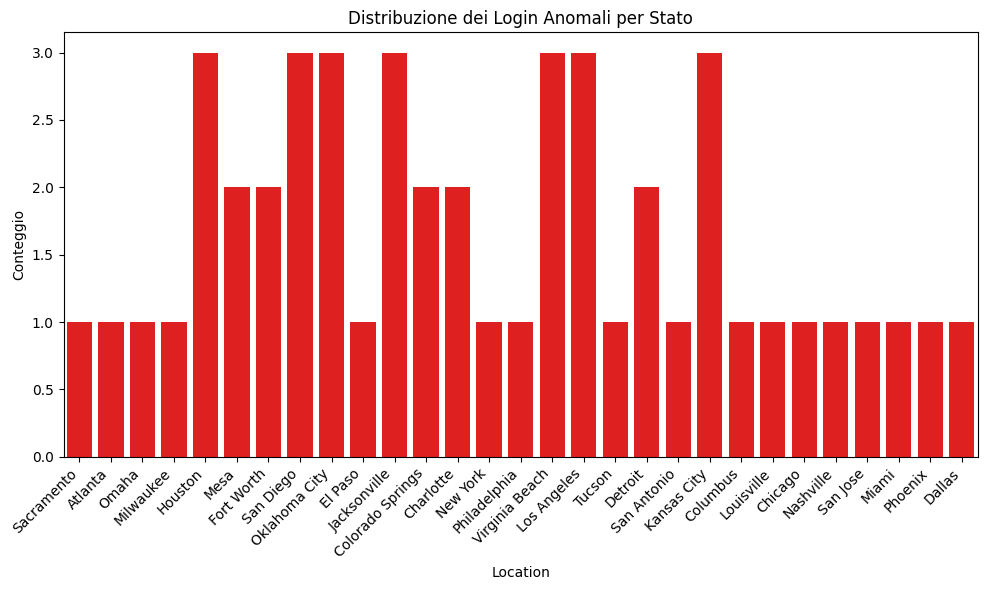

<Figure size 800x600 with 0 Axes>

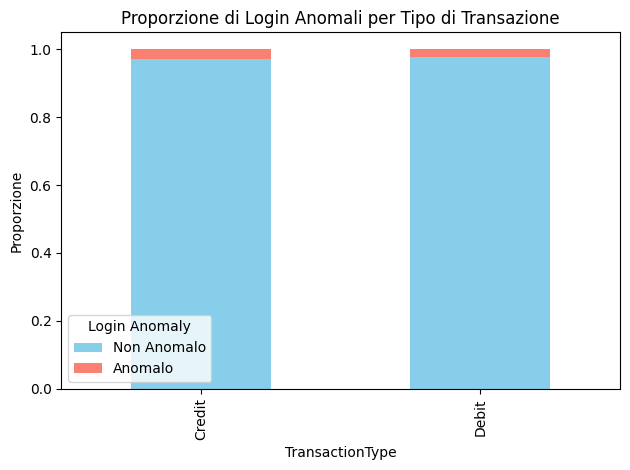

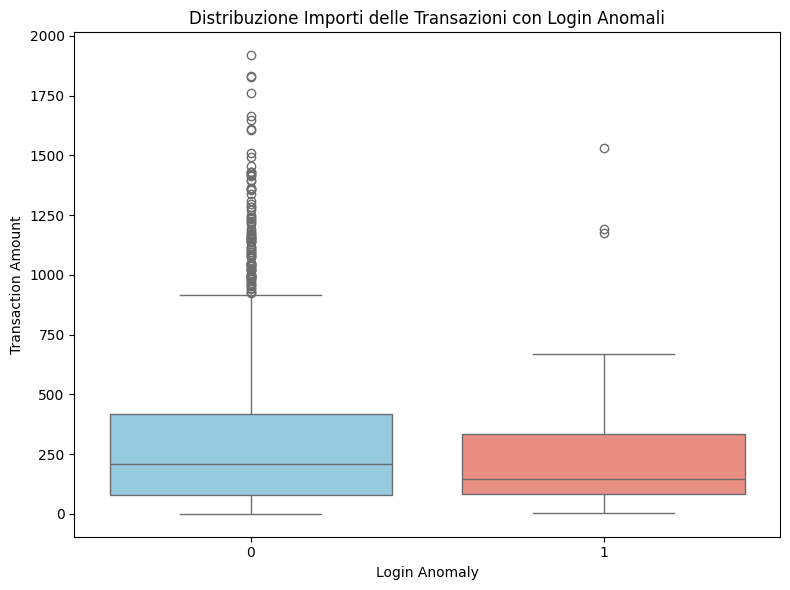

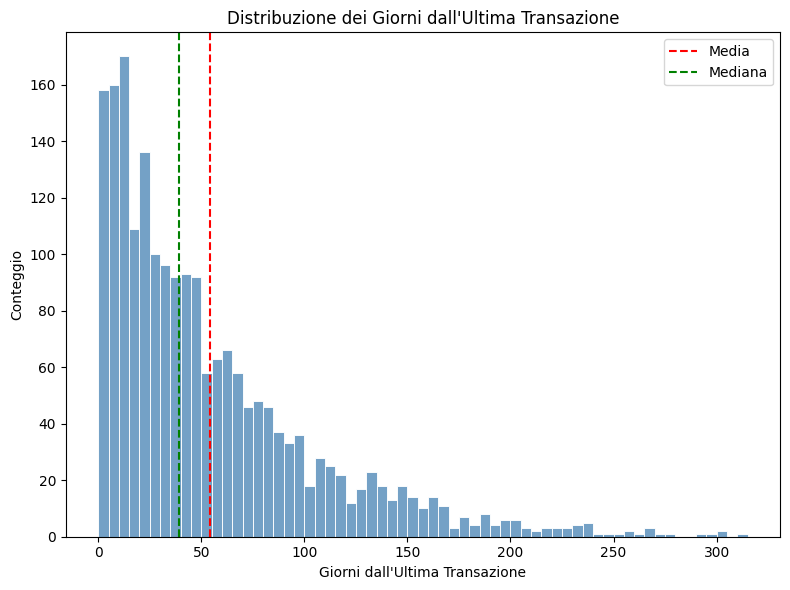

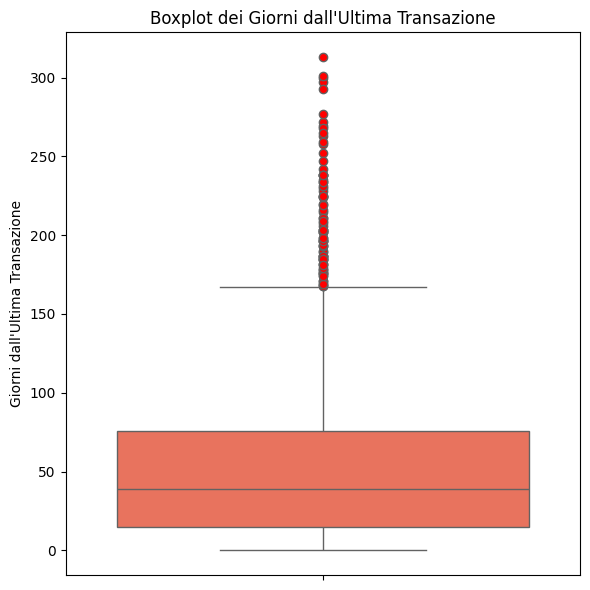

In [13]:

# 3. Plot esplorativi

# 3.1. Distribuzione dei Login Anomali per Stato (Location)
plt.figure(figsize=(10,6))
sns.countplot(data=bank[bank['LoginAnomaly'] == 1], x='Location', color='red')
plt.xticks(rotation=45, ha='right')
plt.title("Distribuzione dei Login Anomali per Stato")
plt.xlabel("Location")
plt.ylabel("Conteggio")
plt.tight_layout()
plt.show()

# 3.2. Proporzione di Login Anomali per Tipo di Transazione
plt.figure(figsize=(8,6))
ct = pd.crosstab(bank['TransactionType'], bank['LoginAnomaly'], normalize='index')
ct.plot(kind='bar', stacked=True, color=['skyblue','salmon'])
plt.title("Proporzione di Login Anomali per Tipo di Transazione")
plt.xlabel("TransactionType")
plt.ylabel("Proporzione")
plt.legend(title="Login Anomaly", labels=["Non Anomalo", "Anomalo"])
plt.tight_layout()
plt.show()

# 3.3. Boxplot degli Importi delle Transazioni in funzione dei Login Anomali
plt.figure(figsize=(8,6))
sns.boxplot(x='LoginAnomaly', y='TransactionAmount', data=bank, palette=['skyblue','salmon'])
plt.title("Distribuzione Importi delle Transazioni con Login Anomali")
plt.xlabel("Login Anomaly")
plt.ylabel("Transaction Amount")
plt.tight_layout()
plt.show()

# 3.4. Distribuzione dei Giorni dall'Ultima Transazione (istogramma con media e mediana)
plt.figure(figsize=(8,6))
bin_width = 5
bins = np.arange(bank['DaysSinceLastTransaction'].min(), bank['DaysSinceLastTransaction'].max()+bin_width, bin_width)
sns.histplot(bank['DaysSinceLastTransaction'], bins=bins, color='steelblue', edgecolor='white')
plt.axvline(bank['DaysSinceLastTransaction'].mean(), color='red', linestyle='dashed', linewidth=1.5, label='Media')
plt.axvline(bank['DaysSinceLastTransaction'].median(), color='green', linestyle='dashed', linewidth=1.5, label='Mediana')
plt.title("Distribuzione dei Giorni dall'Ultima Transazione")
plt.xlabel("Giorni dall'Ultima Transazione")
plt.ylabel("Conteggio")
plt.legend()
plt.tight_layout()
plt.show()

# 3.5. Boxplot dei Giorni dall'Ultima Transazione
plt.figure(figsize=(6,6))
sns.boxplot(y='DaysSinceLastTransaction', data=bank, color='tomato', flierprops={'markerfacecolor': 'red', 'markersize': 6})
plt.title("Boxplot dei Giorni dall'Ultima Transazione")
plt.ylabel("Giorni dall'Ultima Transazione")
plt.tight_layout()
plt.show()

Primi 10 outlier:
     AccountID  DaysSinceLastTransaction     TransactionDate  \
278    AC00009                     234.0 2023-12-25 17:19:08   
1561   AC00015                     196.0 2023-11-06 16:28:15   
1968   AC00016                     176.0 2023-09-12 18:52:56   
1063   AC00025                     269.0 2023-12-08 17:05:35   
596    AC00039                     203.0 2023-07-25 17:21:53   
1144   AC00040                     171.0 2023-07-24 16:18:50   
2417   AC00046                     272.0 2023-10-03 16:39:18   
504    AC00052                     189.0 2023-09-25 16:14:35   
1742   AC00053                     190.0 2023-08-03 18:19:53   
53     AC00055                     230.0 2023-09-07 16:51:27   

     PreviousTransactionDate  
278      2023-05-04 17:43:59  
1561     2023-04-24 16:14:34  
1968     2023-03-20 17:21:43  
1063     2023-03-13 17:10:34  
596      2023-01-03 16:28:03  
1144     2023-02-02 16:19:31  
2417     2023-01-03 17:51:07  
504      2023-03-20 16:08:11 

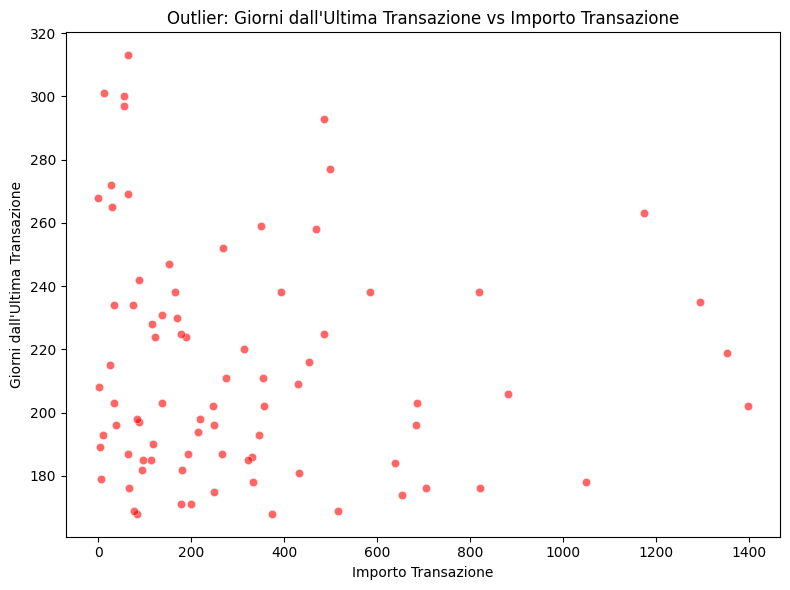

In [14]:

# 3.6. Outlier detection tramite IQR
Q1 = bank['DaysSinceLastTransaction'].quantile(0.25)
Q3 = bank['DaysSinceLastTransaction'].quantile(0.75)
IQR_value = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR_value
upper_bound = Q3 + 1.5 * IQR_value

# Seleziona outliers (transazioni con giorni superiori al bound superiore)
outliers = bank[bank['DaysSinceLastTransaction'] > upper_bound]
print("Primi 10 outlier:")
print(outliers[['AccountID', 'DaysSinceLastTransaction', 'TransactionDate', 'PreviousTransactionDate']].head(10))

# Scatter plot: Importo Transazione vs. Giorni dall'Ultima Transazione per outlier
plt.figure(figsize=(8,6))
sns.scatterplot(x='TransactionAmount', y='DaysSinceLastTransaction', data=outliers, color='red', alpha=0.6)
plt.title("Outlier: Giorni dall'Ultima Transazione vs Importo Transazione")
plt.xlabel("Importo Transazione")
plt.ylabel("Giorni dall'Ultima Transazione")
plt.tight_layout()
plt.show()

# EXPLORATORY DATA ANALYSIS

Numero di righe dopo rimozione NaN: 2017


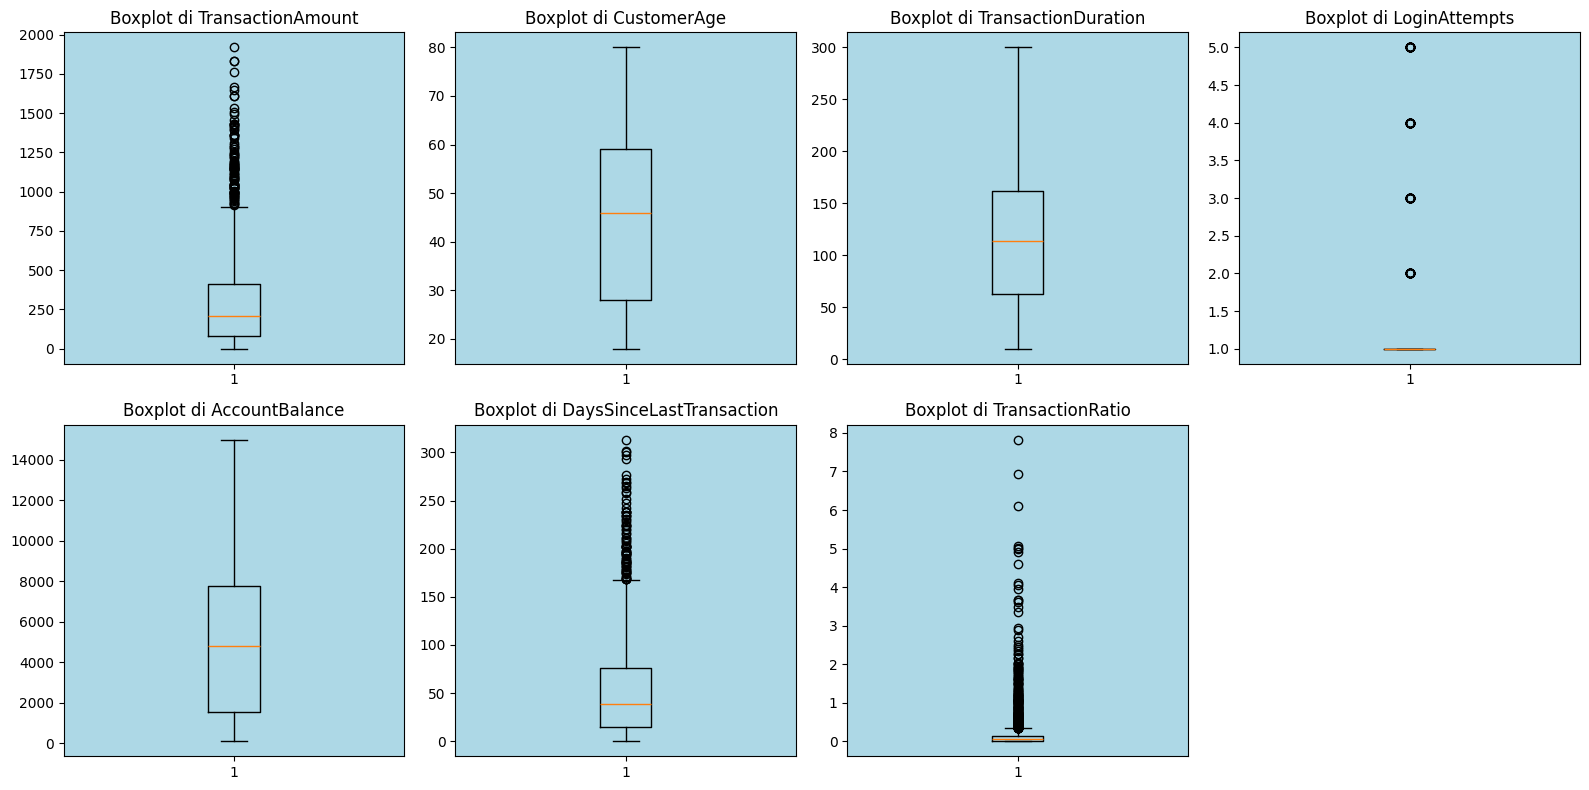

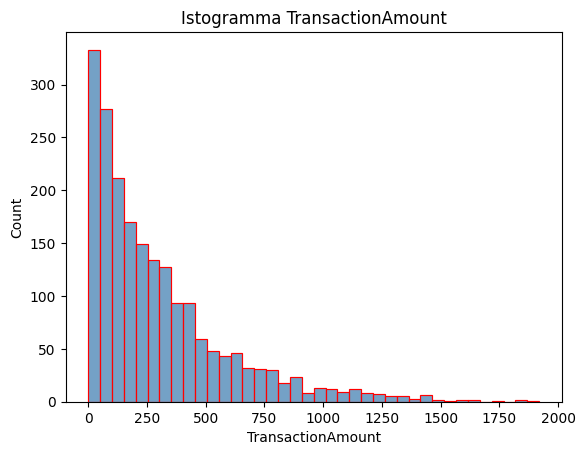

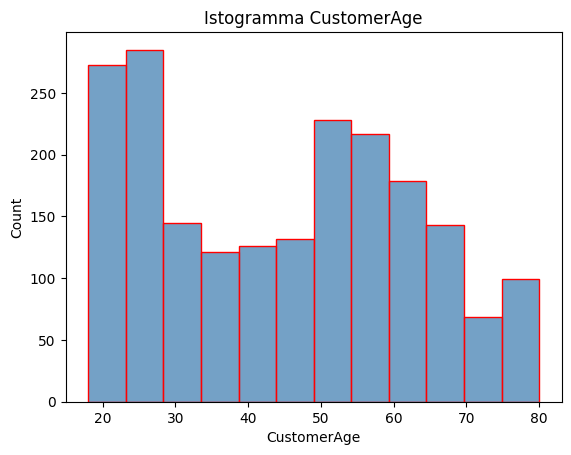

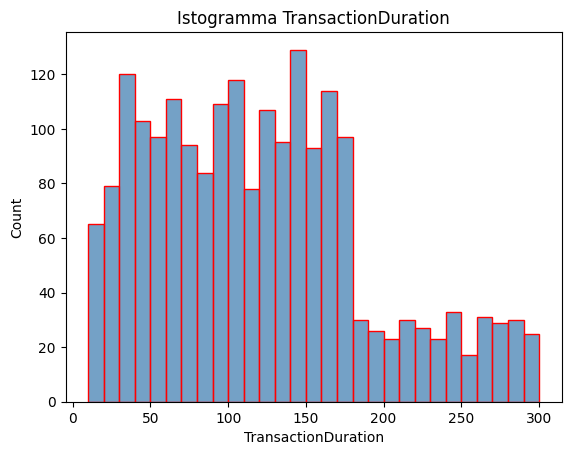

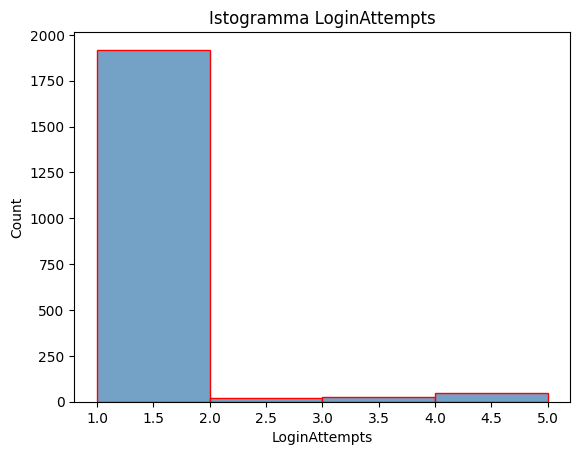

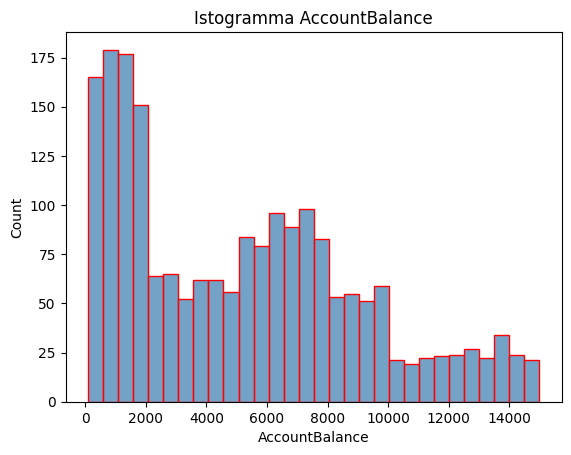

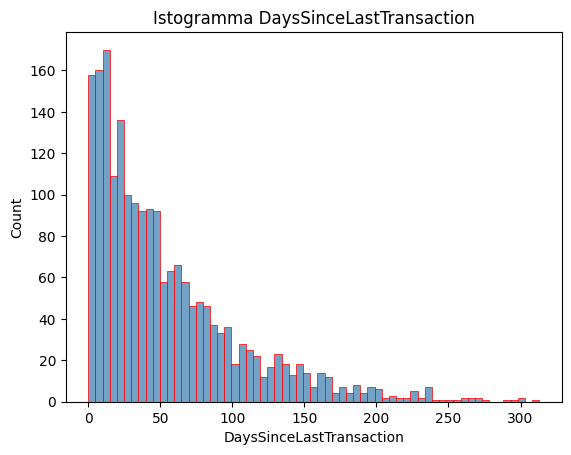

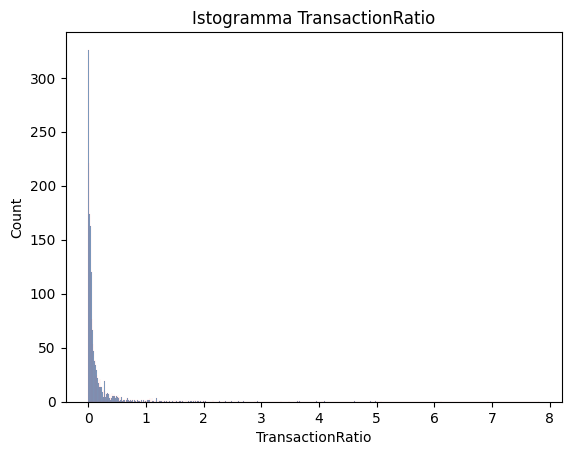

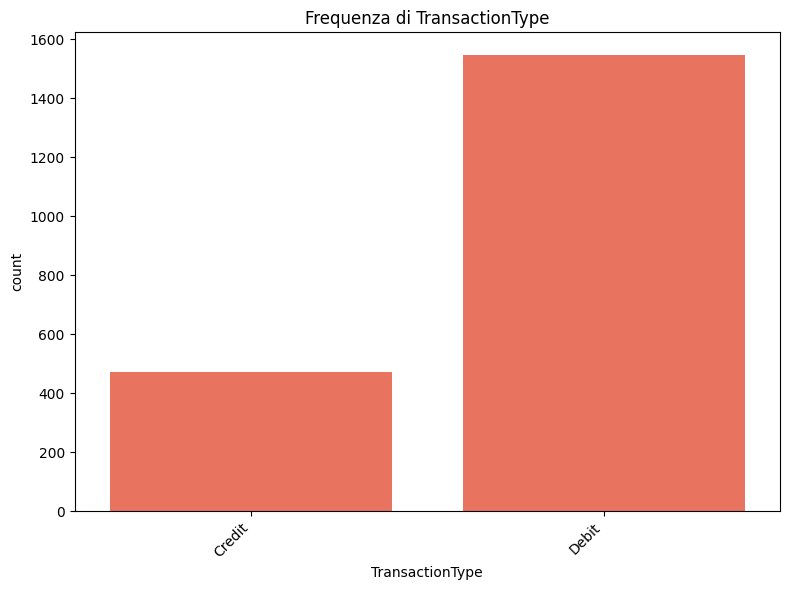

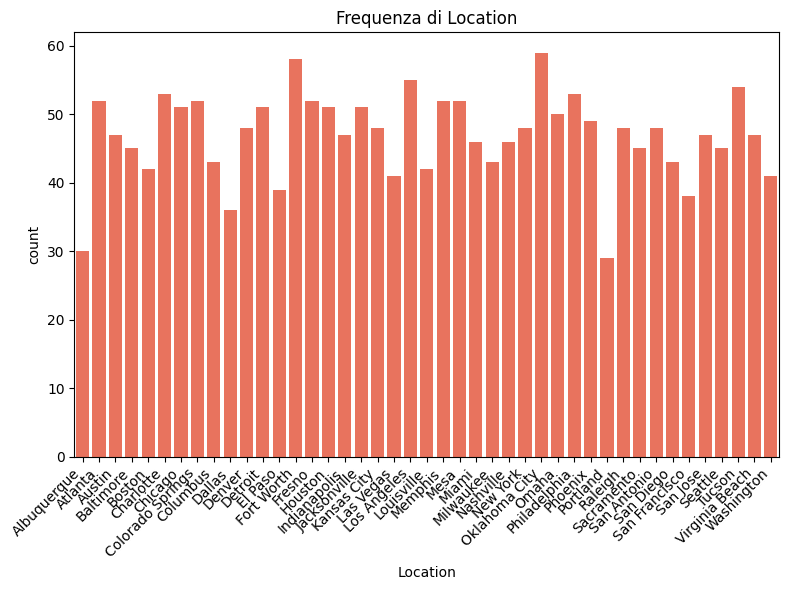

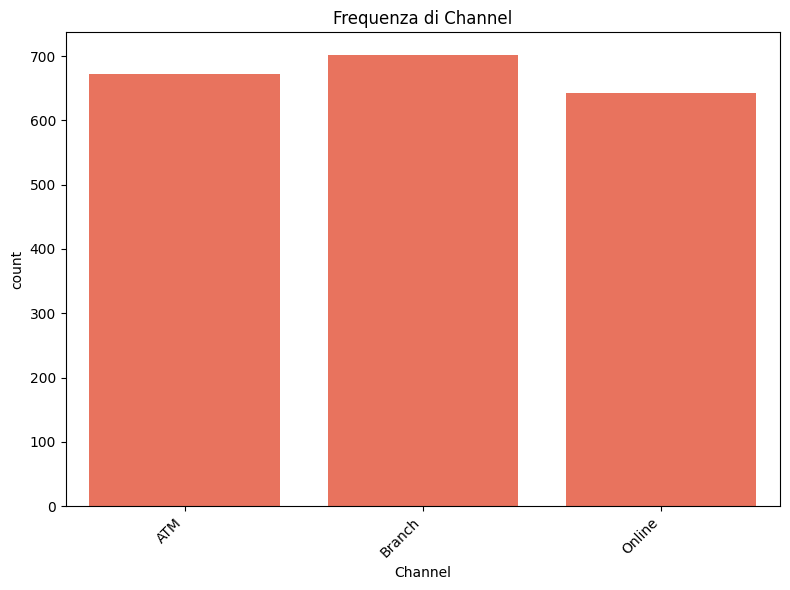

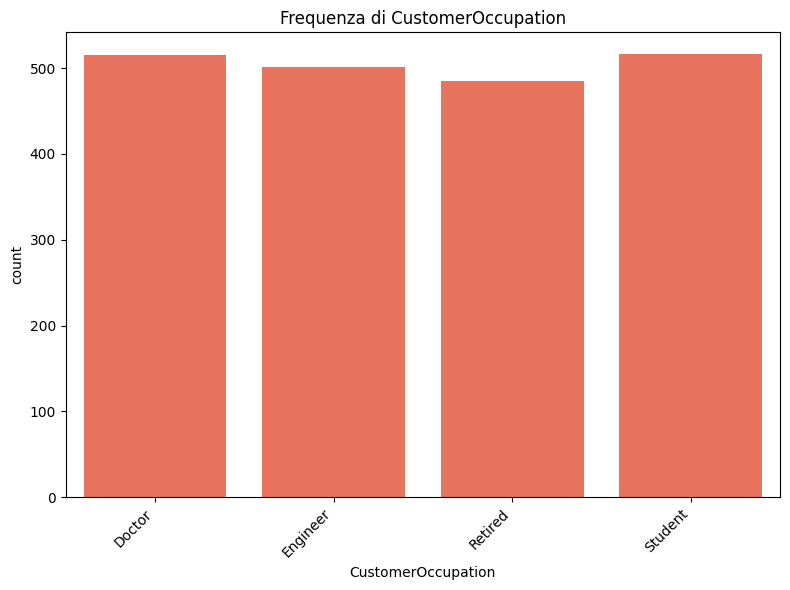

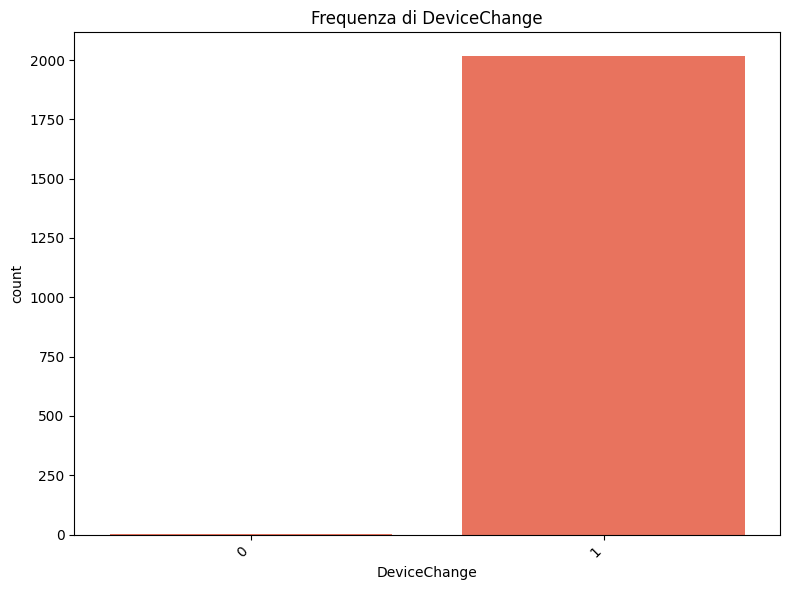

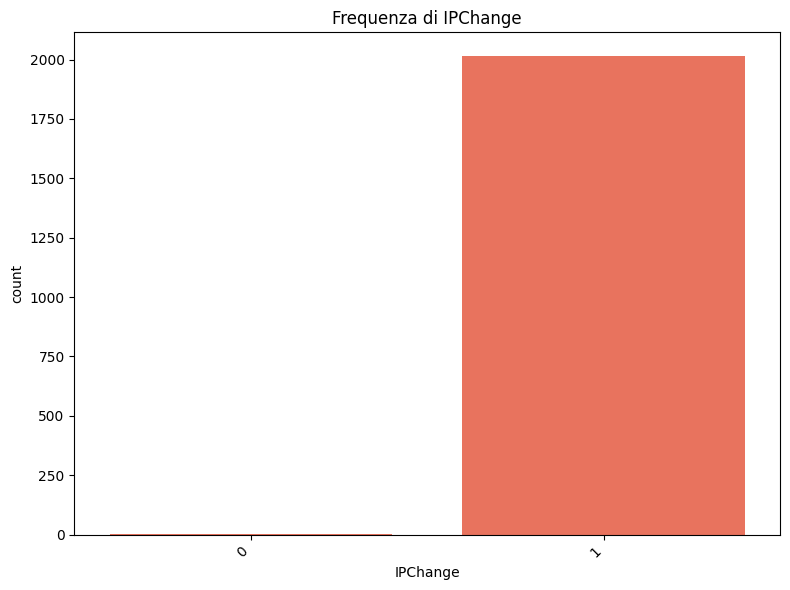

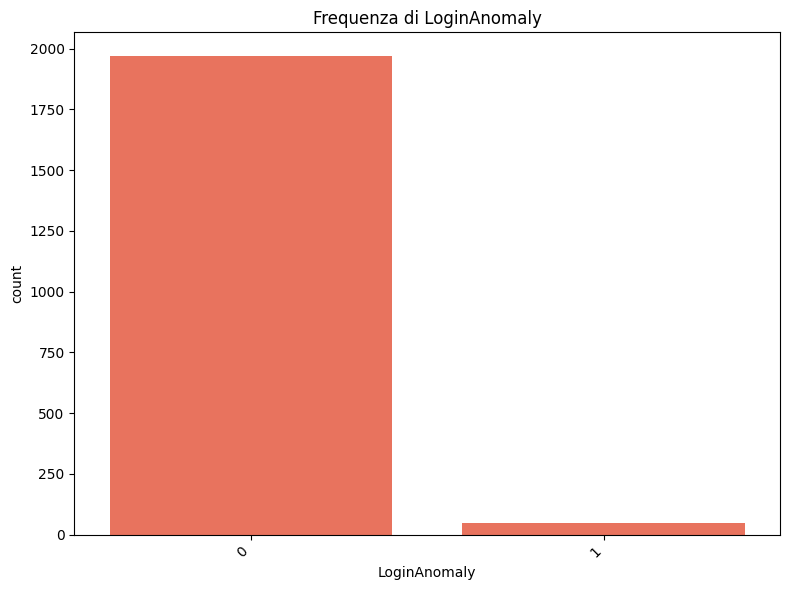

In [15]:
# 4. Analisi Esplorativa (DEA) e visualizzazioni

# Rimozione delle righe con almeno un NaN (se presenti altre colonne)
bank = bank.dropna()
print("Numero di righe dopo rimozione NaN:", bank.shape[0])

# Definizione delle variabili categoriche e numeriche
categorical_vars = ["TransactionID", "AccountID", "TransactionType", "Location",
                      "DeviceID", "IP.Address", "MerchantID", "Channel", "CustomerOccupation",
                      "DeviceChange", "IPChange", "LoginAnomaly"]
numeric_vars = ["TransactionAmount", "CustomerAge", "TransactionDuration",
                "LoginAttempts", "AccountBalance", "DaysSinceLastTransaction", "TransactionRatio"]

# Conversione in categoria
for var in categorical_vars:
    if var in bank.columns:
        bank[var] = bank[var].astype('category')

# 4.1. Boxplot per variabili numeriche (griglia 2x4)
num_plots = len(numeric_vars)
fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs = axs.flatten()
for i, var in enumerate(numeric_vars):
    if var in bank.columns:
        axs[i].boxplot(bank[var])
        axs[i].set_title(f"Boxplot di {var}")
        axs[i].set_facecolor('lightblue')
for j in range(i+1, len(axs)):
    axs[j].axis('off')
plt.tight_layout()
plt.show()

# 4.2. Istogrammi per variabili numeriche usando seaborn
# Creiamo i singoli plot
p1 = sns.histplot(bank['TransactionAmount'], binwidth=50, color='steelblue', edgecolor='red').set_title("Istogramma TransactionAmount")
plt.figure()
p2 = sns.histplot(bank['CustomerAge'], binwidth=5, color='steelblue', edgecolor='red').set_title("Istogramma CustomerAge")
plt.figure()
p3 = sns.histplot(bank['TransactionDuration'], binwidth=10, color='steelblue', edgecolor='red').set_title("Istogramma TransactionDuration")
plt.figure()
p4 = sns.histplot(bank['LoginAttempts'], binwidth=1, color='steelblue', edgecolor='red').set_title("Istogramma LoginAttempts")
plt.figure()
p5 = sns.histplot(bank['AccountBalance'], binwidth=500, color='steelblue', edgecolor='red').set_title("Istogramma AccountBalance")
plt.figure()
p6 = sns.histplot(bank['DaysSinceLastTransaction'], binwidth=5, color='steelblue', edgecolor='red').set_title("Istogramma DaysSinceLastTransaction")
plt.figure()
p7 = sns.histplot(bank['TransactionRatio'], binwidth=0.01, color='steelblue', edgecolor='red').set_title("Istogramma TransactionRatio")
plt.show()

# 4.3. Funzione per plottare le frequenze delle variabili categoriche
def plot_frequency(var, var_name):
    plt.figure(figsize=(8,6))
    sns.countplot(x=var, color='tomato')
    plt.title(f"Frequenza di {var_name}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plottiamo per alcune variabili categoriche
plot_frequency(bank['TransactionType'], "TransactionType")
plot_frequency(bank['Location'], "Location")
plot_frequency(bank['Channel'], "Channel")
plot_frequency(bank['CustomerOccupation'], "CustomerOccupation")
plot_frequency(bank['DeviceChange'], "DeviceChange")
plot_frequency(bank['IPChange'], "IPChange")
plot_frequency(bank['LoginAnomaly'], "LoginAnomaly")


# PCA

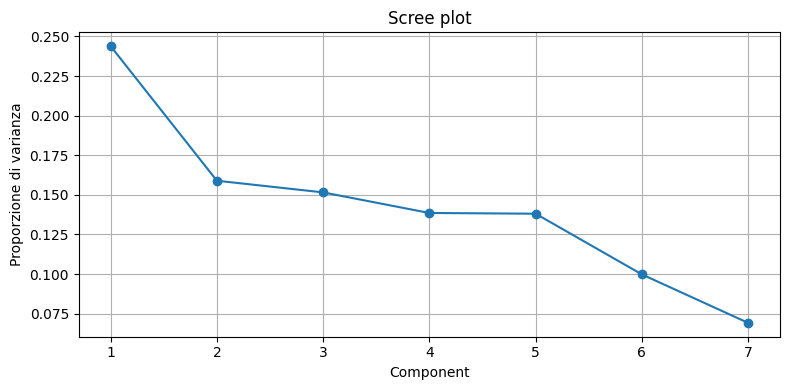

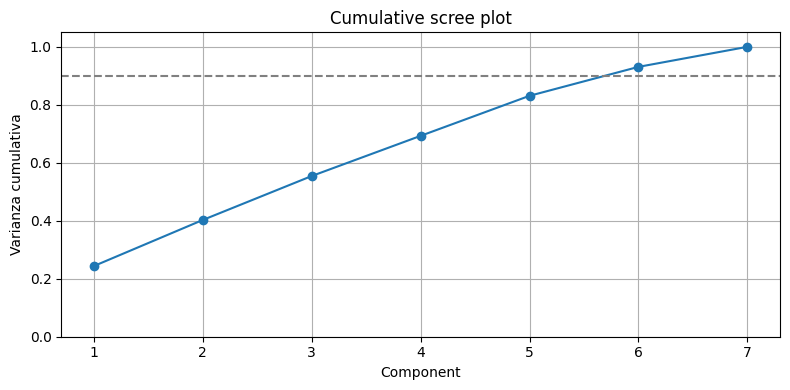

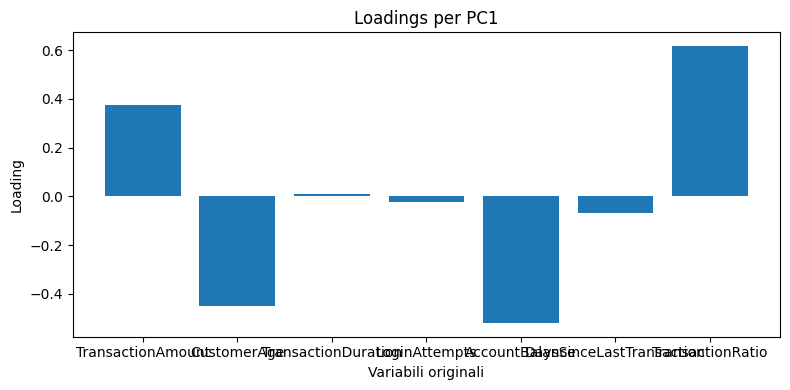

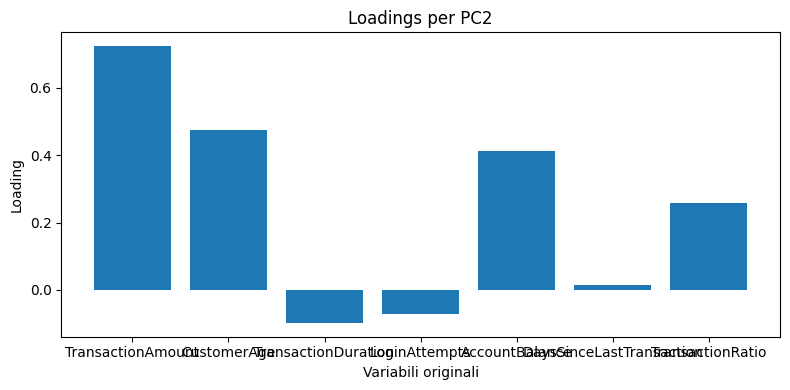

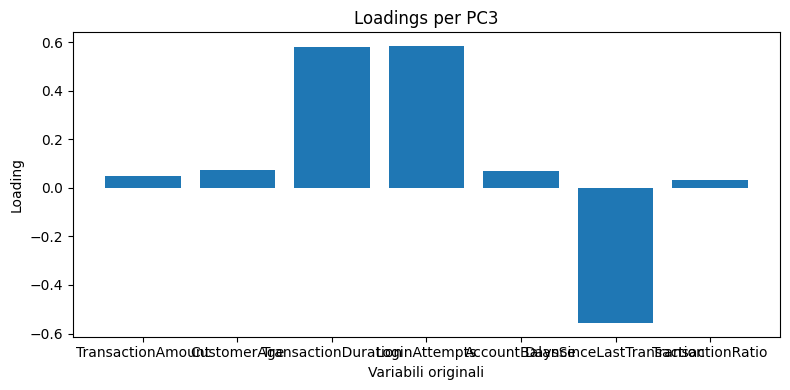

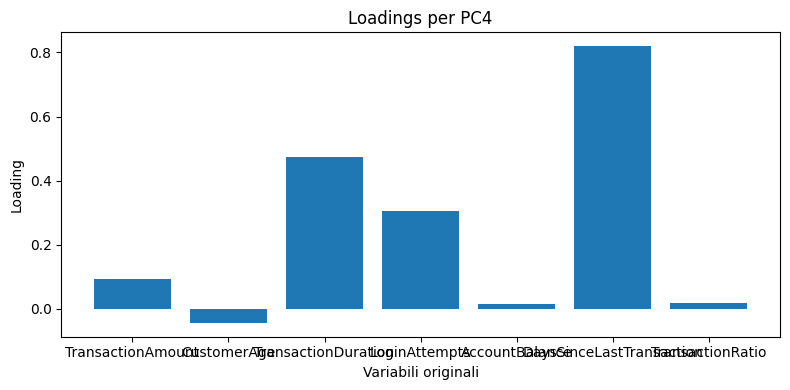

In [16]:
# 5. PCA sulle variabili numeriche
num_data = bank[numeric_vars].select_dtypes(include=[np.number])

# Standardizzazione
scaler = StandardScaler()
num_data_scaled = scaler.fit_transform(num_data)

pca = PCA()
pca_res = pca.fit(num_data_scaled)
explained_variance = pca.explained_variance_ratio_
cum_variance = np.cumsum(explained_variance)

# Scree plot: proporzione di varianza per componente
plt.figure(figsize=(8,4))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title("Scree plot")
plt.xlabel("Component")
plt.ylabel("Proporzione di varianza")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scree plot cumulativo
plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_variance)+1), cum_variance, marker='o')
plt.title("Cumulative scree plot")
plt.xlabel("Component")
plt.ylabel("Varianza cumulativa")
plt.ylim(0,1.05)
plt.axhline(0.9, color='gray', linestyle='dashed')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizzazione dei loadings (barplot per le prime 4 componenti)
loadings = pca.components_.T
num_vars = num_data.shape[1]
components = ['PC1', 'PC2', 'PC3', 'PC4']
for i, comp in enumerate(components):
    plt.figure(figsize=(8,4))
    plt.bar(range(num_vars), loadings[:, i], tick_label=num_data.columns)
    plt.title(f"Loadings per {comp}")
    plt.xlabel("Variabili originali")
    plt.ylabel("Loading")
    plt.tight_layout()
    plt.show()


# CLUSTERING

In [17]:
# 5.1. Test di Bartlett per la sfericità
chi_square_value, p_value = calculate_bartlett_sphericity(num_data)
print("Bartlett's test chi-square:", chi_square_value, "p-value:", p_value)

Bartlett's test chi-square: 901.5780111841555 p-value: 2.4686605505705713e-177


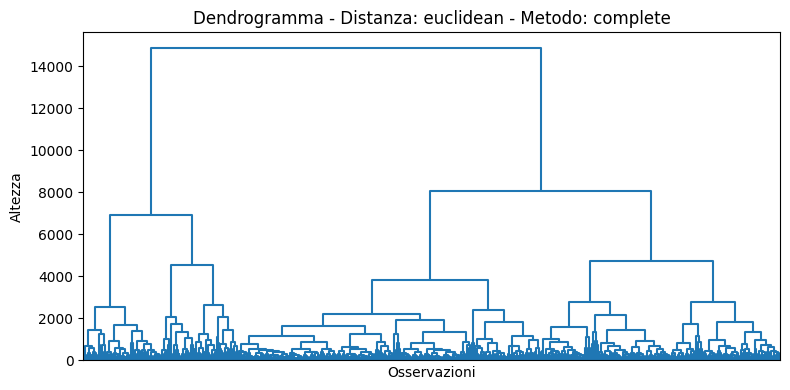

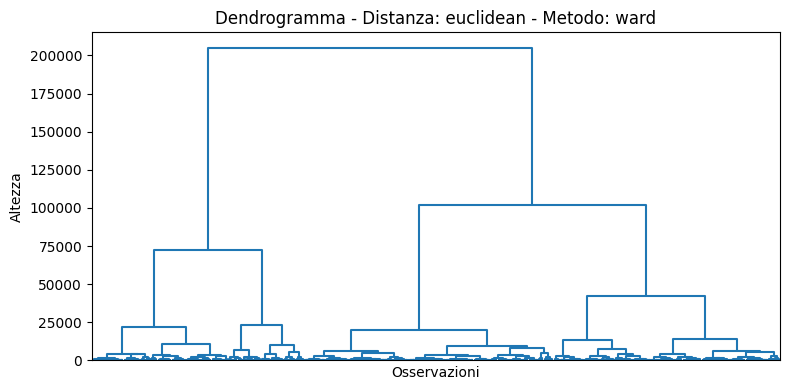

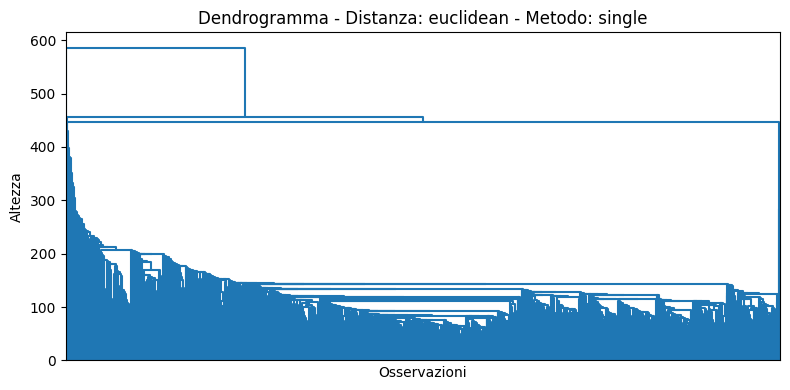

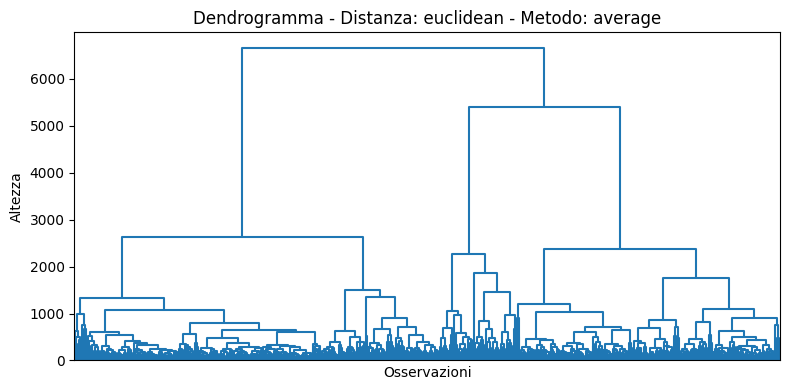

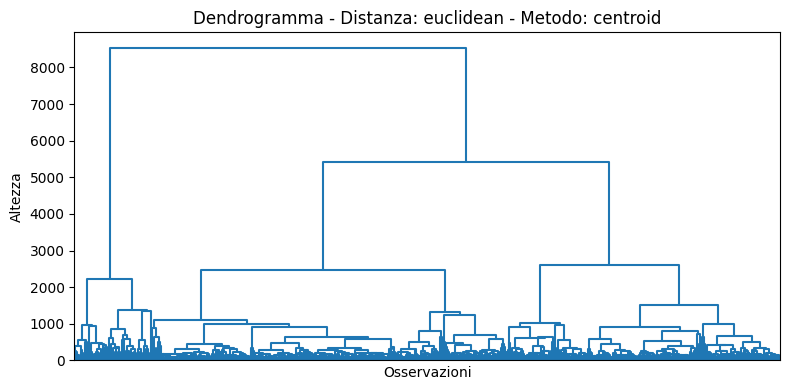

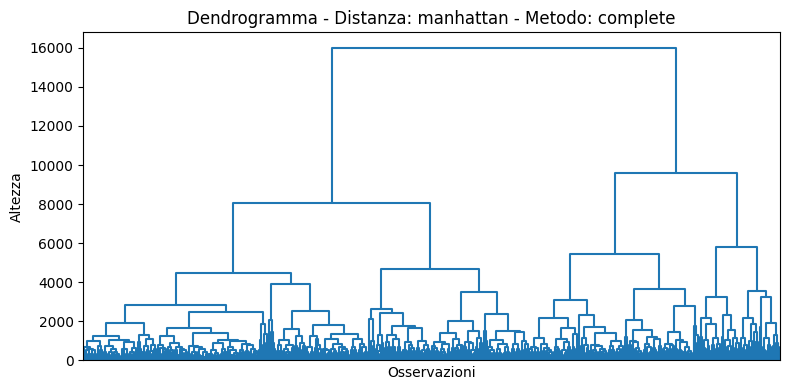

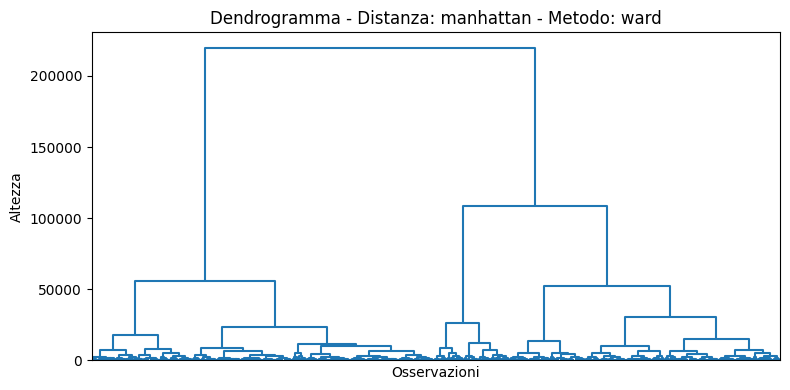

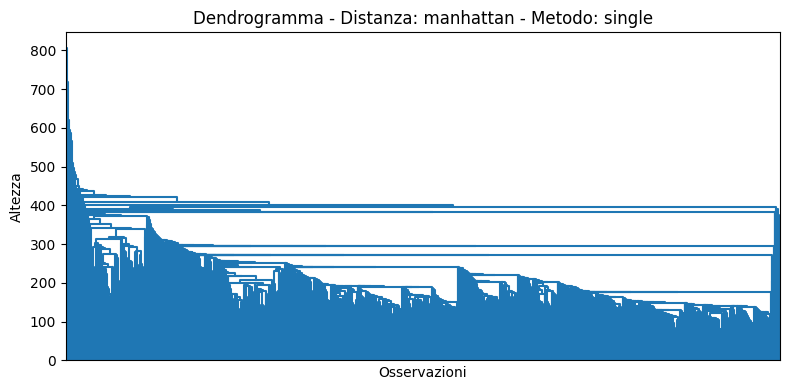

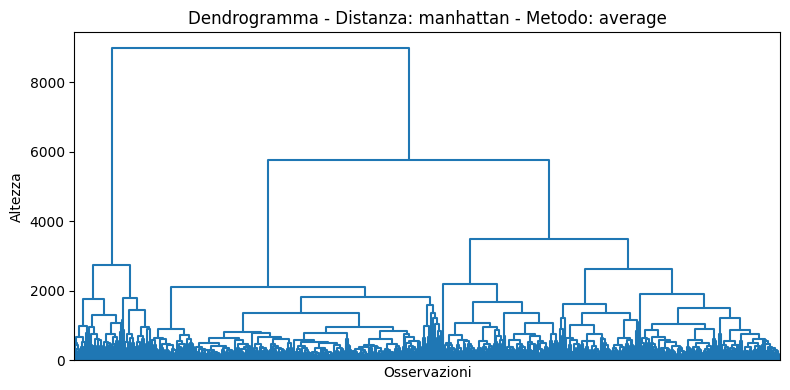

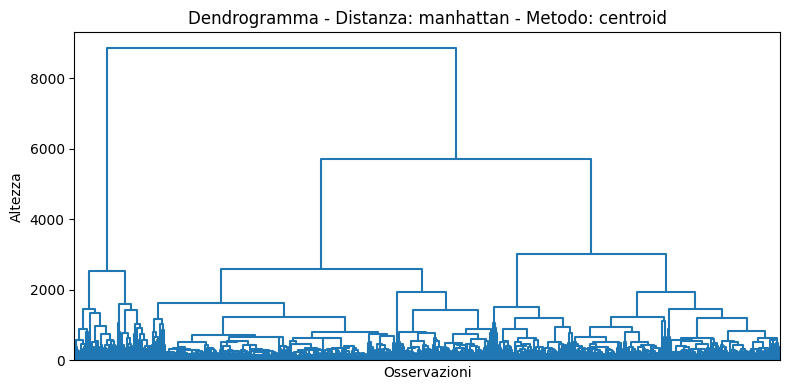

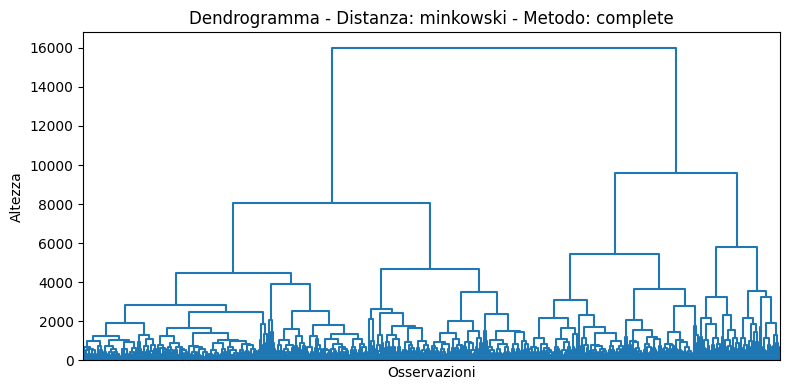

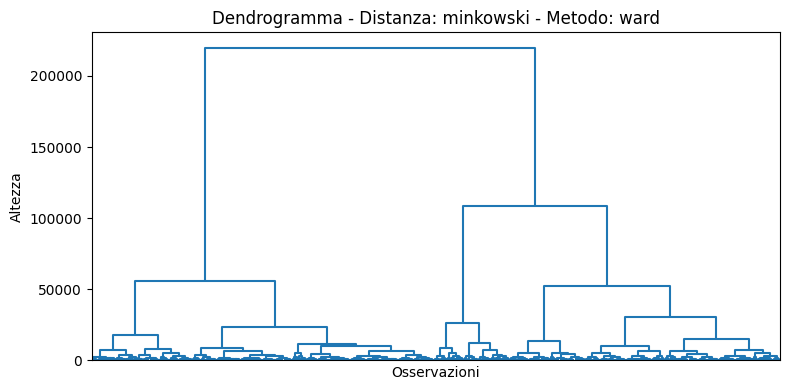

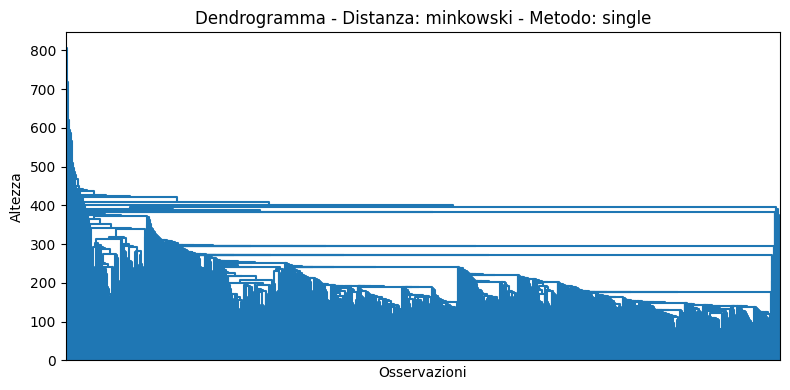

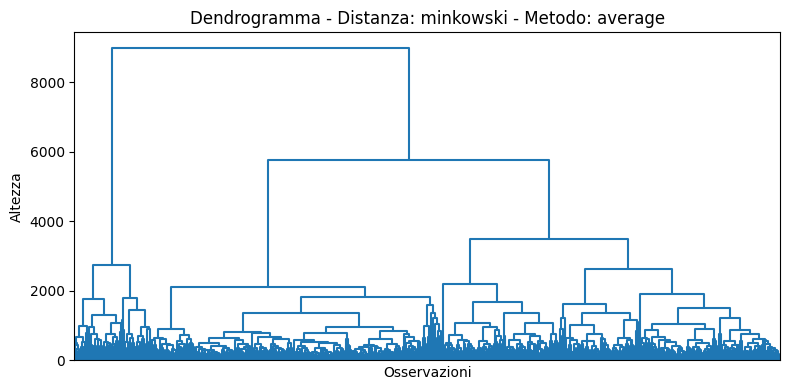

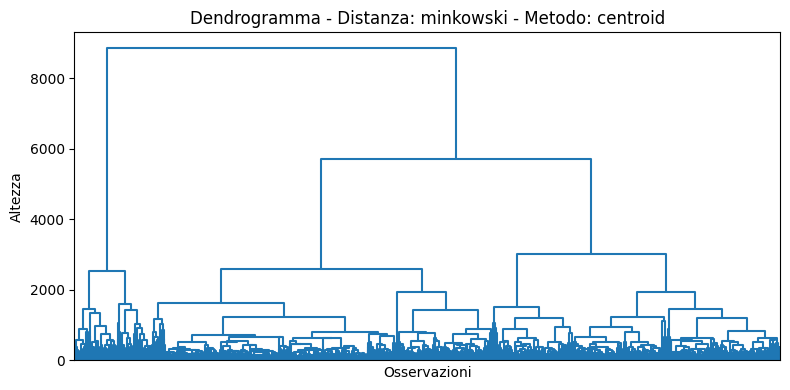

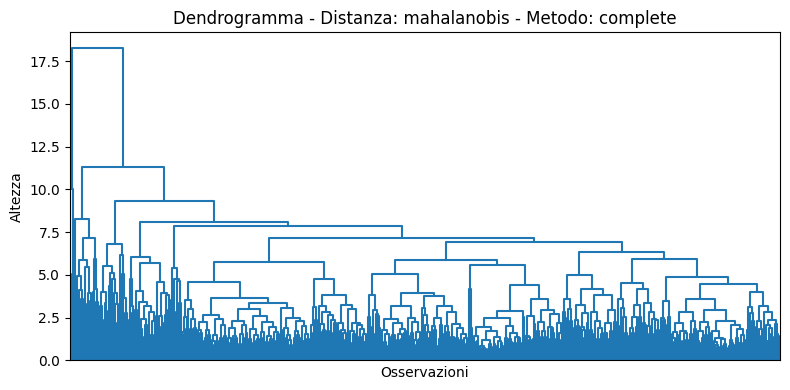

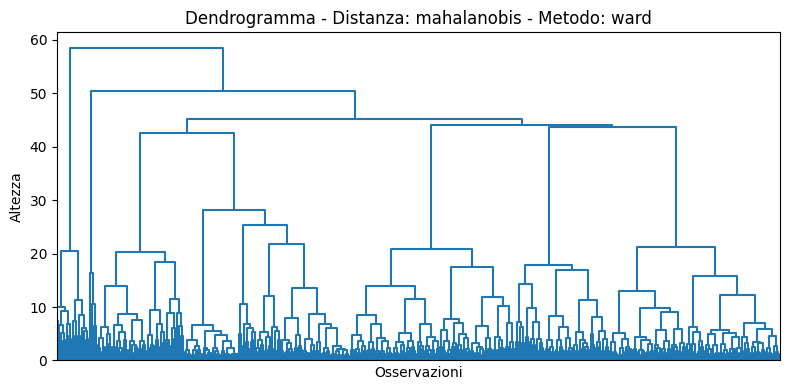

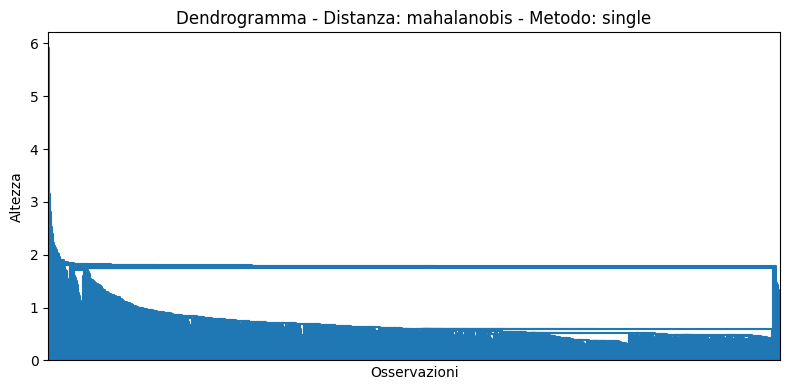

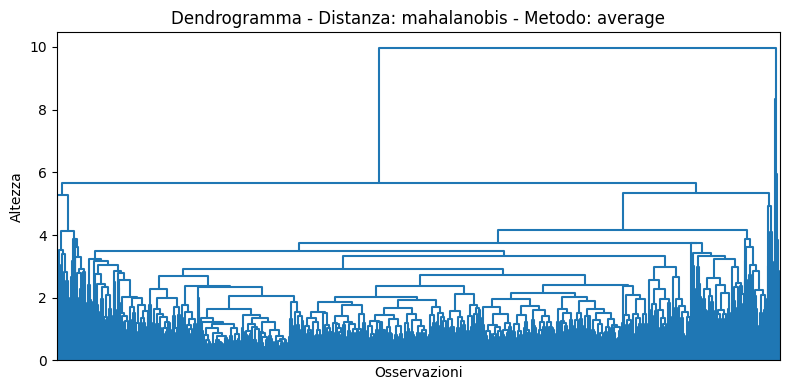

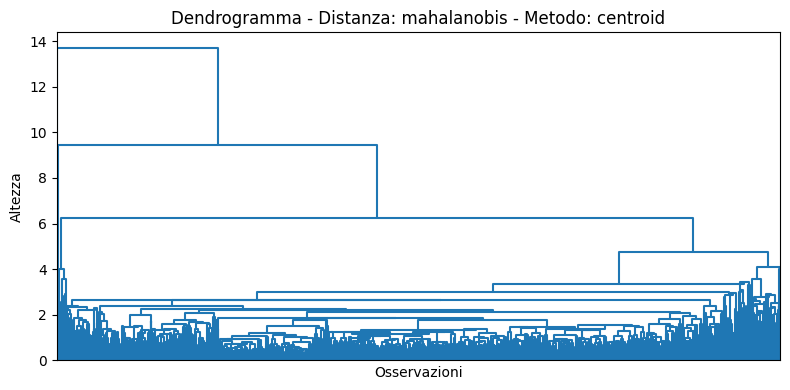

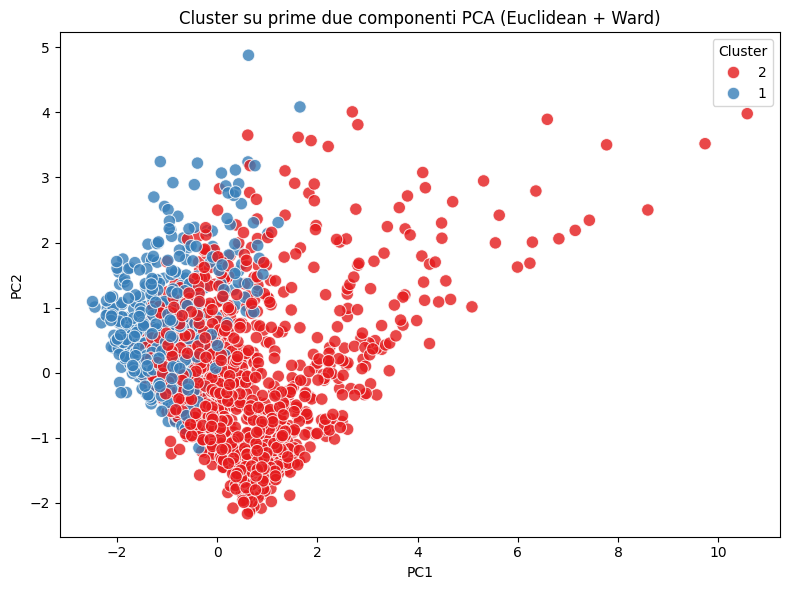

In [18]:
# 7. Preparazione al clustering

# Creazione di variabili logaritmiche
bank['LogTransactionAmount'] = np.log(bank['TransactionAmount'] + 1)
bank['LogTransactionRatio'] = np.log(bank['TransactionRatio'] + 1)

# Standardizzazione delle variabili quantitative per il clustering
scaler_cluster = StandardScaler()
bank['StandardizedTransactionAmount'] = scaler_cluster.fit_transform(bank[['LogTransactionAmount']])
bank['StandardizedTransactionRatio'] = scaler_cluster.fit_transform(bank[['LogTransactionRatio']])
bank['StandardizedTransactionDuration'] = scaler_cluster.fit_transform(bank[['TransactionDuration']])
bank['StandardizedLoginAttempts'] = scaler_cluster.fit_transform(bank[['LoginAttempts']])
bank['StandardizedAccountBalance'] = scaler_cluster.fit_transform(bank[['AccountBalance']])
bank['StandardizedDaysSinceLastTransaction'] = scaler_cluster.fit_transform(bank[['DaysSinceLastTransaction']])
# Per IPChange, convertiamo in numerico e standardizziamo
bank['StandardizedIPChange'] = scaler_cluster.fit_transform(bank[['IPChange']].astype(float))

# Se si volesse fare one-hot encoding delle variabili categoriche:
one_hot_encoded = pd.get_dummies(bank[["TransactionType", "Location", "Channel", "CustomerOccupation"]], drop_first=True)
# Per il clustering finale, usiamo solo le variabili quantitative standardizzate
final_cols = ["StandardizedTransactionAmount", "StandardizedTransactionRatio",
              "StandardizedTransactionDuration", "StandardizedLoginAttempts",
              "StandardizedAccountBalance", "StandardizedIPChange", "StandardizedDaysSinceLastTransaction"]
final_data = bank[final_cols].copy()

# 8. Clustering gerarchico

# Calcolo delle matrici di distanza
from scipy.spatial.distance import pdist

euclidean_dist = pdist(num_data, metric='euclidean')
manhattan_dist = pdist(num_data, metric='cityblock')
# Minkowski con p=1 è equivalente a manhattan, ma lo calcoliamo separatamente
minkowski_dist = pdist(num_data, metric='minkowski', p=1)

# Per la distanza di Mahalanobis, calcoliamo l'inverso della matrice di covarianza
VI = np.linalg.inv(np.cov(num_data_scaled.T))
# Definiamo una funzione per calcolare la distanza di Mahalanobis per ogni coppia
def mahalanobis_distance(u, v, VI):
    diff = u - v
    return np.sqrt(np.dot(np.dot(diff, VI), diff.T))
# Usiamo pdist passando un lambda
mahalanobis_dist = pdist(num_data_scaled, metric=lambda u, v: mahalanobis_distance(u, v, VI))

# Metodi di linkage da testare
methods = ['complete', 'ward', 'single', 'average', 'centroid']
distances = {
    'euclidean': euclidean_dist,
    'manhattan': manhattan_dist,
    'minkowski': minkowski_dist,
    'mahalanobis': mahalanobis_dist
}

# Iteriamo per plottare dendrogrammi per ogni combinazione
for dist_name, dist_matrix in distances.items():
    for method in methods:
        # In scipy, il metodo 'ward' equivale a ward.D2 e non è compatibile con metriche non euclidee
        try:
            Z = linkage(dist_matrix, method=method)
            plt.figure(figsize=(8, 4))
            dendrogram(Z, no_labels=True, color_threshold=0)
            plt.title(f"Dendrogramma - Distanza: {dist_name} - Metodo: {method}")
            plt.xlabel("Osservazioni")
            plt.ylabel("Altezza")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Impossibile calcolare linkage per {dist_name} con metodo {method}: {e}")

# Taglio del dendrogramma per ottenere 2 cluster (esempio: euclidean + ward)
# Calcoliamo il linkage con euclidean e ward (ward è compatibile con euclidea)
Z_euclidean = linkage(euclidean_dist, method='ward')
clusters_euclidean = fcluster(Z_euclidean, t=2, criterion='maxclust')
# Creiamo un dataframe con le prime due componenti PCA e l'assegnazione ai cluster
pca_2 = PCA(n_components=2)
pca_2_res = pca_2.fit_transform(num_data_scaled)
pca_df = pd.DataFrame({
    'PC1': pca_2_res[:,0],
    'PC2': pca_2_res[:,1],
    'Cluster': clusters_euclidean.astype(str)
})
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=80, alpha=0.8)
plt.title("Cluster su prime due componenti PCA (Euclidean + Ward)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# DBSCAN AND LOF

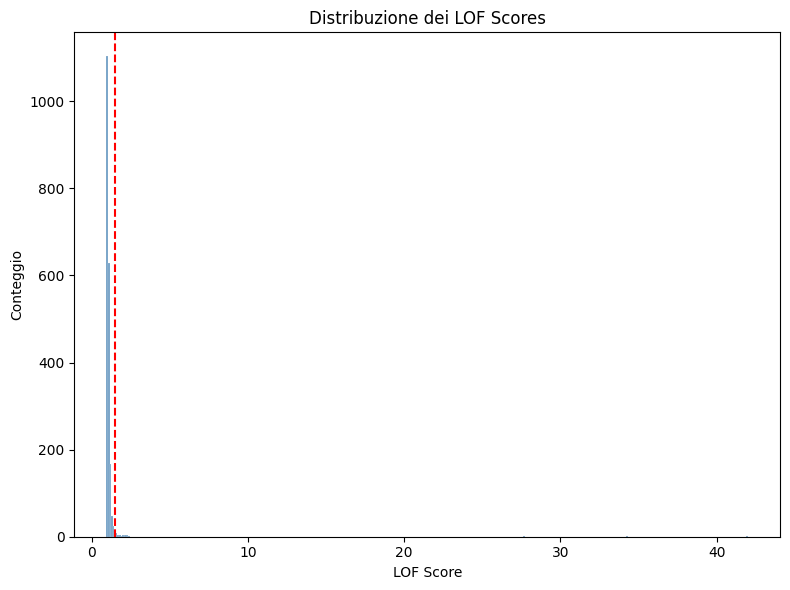

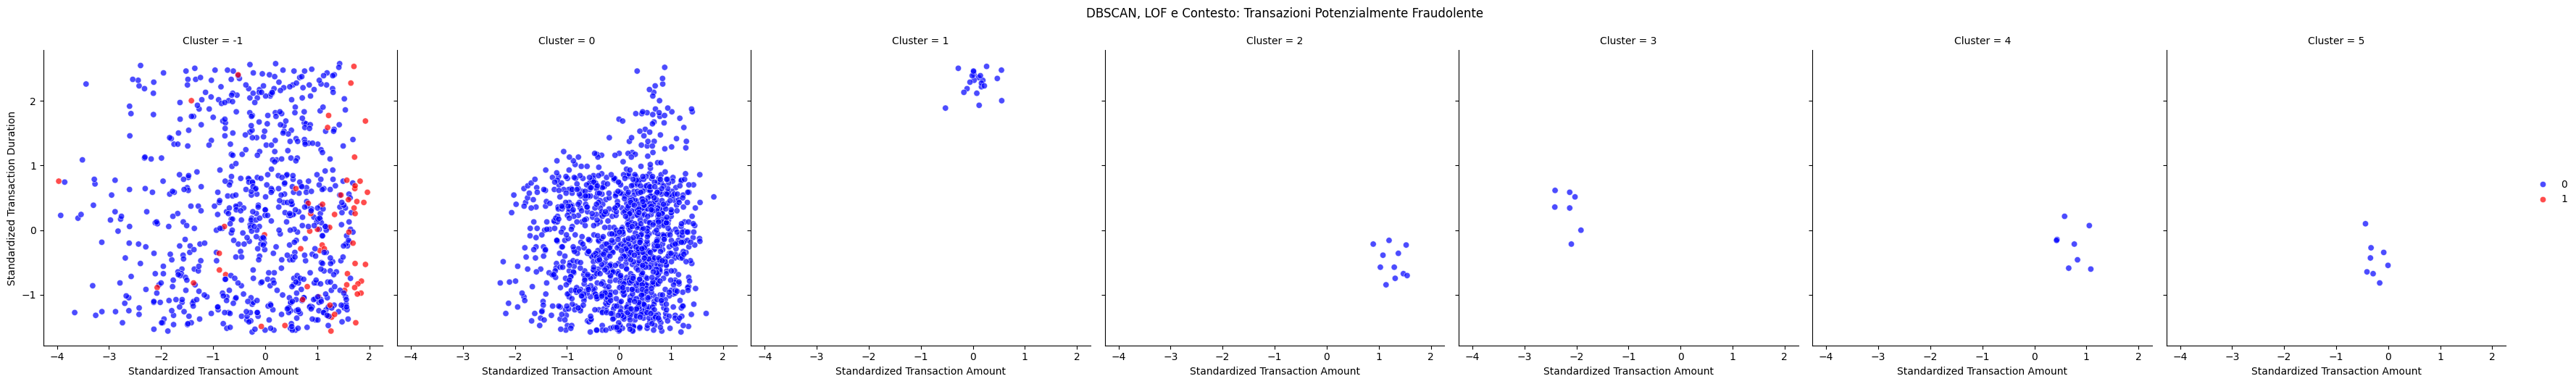

Riepilogo dei casi sospetti per cluster:
   Cluster  Totale  Sospetti
0       -1     759        62
1        0    1202         0
2        1      22         0
3        2      11         0
4        3       7         0
5        4       8         0
6        5       8         0


In [19]:
# 9. Clustering con DBSCAN e analisi LOF

# Per DBSCAN usiamo il dataset final_data (solo quantitativo)
X = final_data.copy()

# DBSCAN: eps = 0.6, min_samples = 8
dbscan_model = DBSCAN(eps=0.6, min_samples=8)
dbscan_labels = dbscan_model.fit_predict(X)
final_data['Cluster'] = dbscan_labels  # In scikit-learn, il rumore viene etichettato come -1

# Calcolo dei LOF scores con k = 10
lof_model = LocalOutlierFactor(n_neighbors=10, contamination='auto')
lof_scores = -lof_model.fit_predict(X)  # il metodo fit_predict restituisce -1 per outlier, ma usiamo .negative_outlier_factor_
lof_scores = -lof_model.negative_outlier_factor_
final_data['LOF'] = lof_scores

# Calcolo dei threshold al 99° percentile per alcune variabili standardizzate
amount_threshold = final_data['StandardizedTransactionAmount'].quantile(0.99)
ratio_threshold  = final_data['StandardizedTransactionRatio'].quantile(0.99)
login_threshold  = final_data['StandardizedLoginAttempts'].quantile(0.99)
days_threshold   = final_data['StandardizedDaysSinceLastTransaction'].quantile(0.99)
ip_threshold     = final_data['StandardizedIPChange'].quantile(0.99)

# Creiamo la variabile ContextFlag se almeno una condizione supera il threshold
final_data['ContextFlag'] = np.where(
    (final_data['StandardizedTransactionAmount'] > amount_threshold) |
    (final_data['StandardizedTransactionRatio'] > ratio_threshold) |
    (final_data['StandardizedLoginAttempts'] > login_threshold) |
    (final_data['StandardizedDaysSinceLastTransaction'] > days_threshold) |
    (final_data['StandardizedIPChange'] > ip_threshold),
    1, 0
)

# Identificazione dei potenziali casi fraudolenti:
# In DBSCAN in sklearn, il rumore ha etichetta -1 (in R era 0)
final_data['PotentialFraud'] = np.where(
    ((final_data['LOF'] > 1.5) & (final_data['ContextFlag'] == 1)) |
    ((final_data['Cluster'] == -1) & (final_data['ContextFlag'] == 1)),
    1, 0
)

# Plot: distribuzione dei LOF scores con soglia 1.5
plt.figure(figsize=(8,6))
sns.histplot(final_data['LOF'], binwidth=0.1, color='steelblue', edgecolor='white')
plt.axvline(1.5, color='red', linestyle='dashed')
plt.title("Distribuzione dei LOF Scores")
plt.xlabel("LOF Score")
plt.ylabel("Conteggio")
plt.tight_layout()
plt.show()

# Scatter plot: StandardizedTransactionAmount vs StandardizedTransactionDuration, colorando per PotentialFraud e faceting per Cluster
g = sns.FacetGrid(final_data, col="Cluster", height=5, aspect=1)
g.map_dataframe(sns.scatterplot, x="StandardizedTransactionAmount", y="StandardizedTransactionDuration", hue="PotentialFraud", palette={0:'blue',1:'red'}, alpha=0.7)
g.add_legend()
g.set_axis_labels("Standardized Transaction Amount", "Standardized Transaction Duration")
g.fig.suptitle("DBSCAN, LOF e Contesto: Transazioni Potenzialmente Fraudolente", y=1.05)
plt.show()

# Riepilogo dei casi sospetti per cluster
fraud_summary = final_data.groupby('Cluster').agg(Totale=('Cluster', 'count'),
                                                  Sospetti=('PotentialFraud', 'sum')).reset_index()
print("Riepilogo dei casi sospetti per cluster:")
print(fraud_summary)


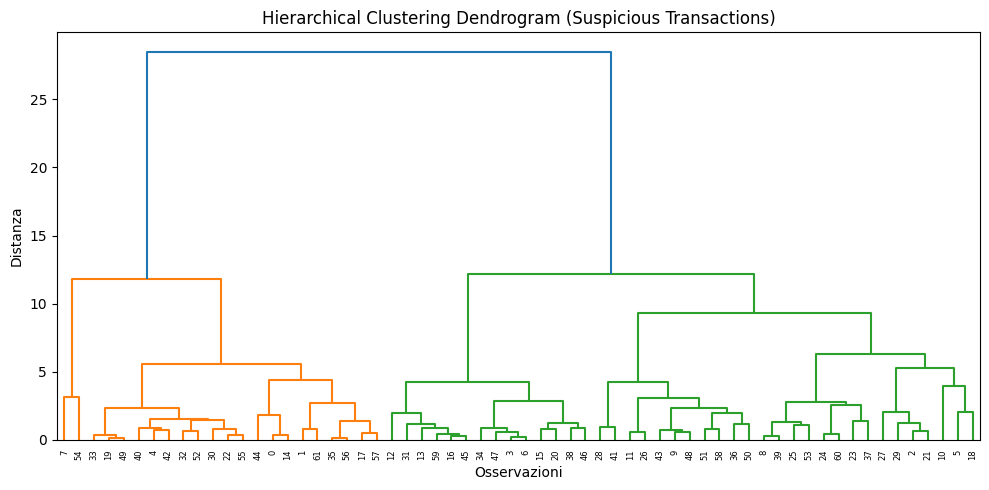

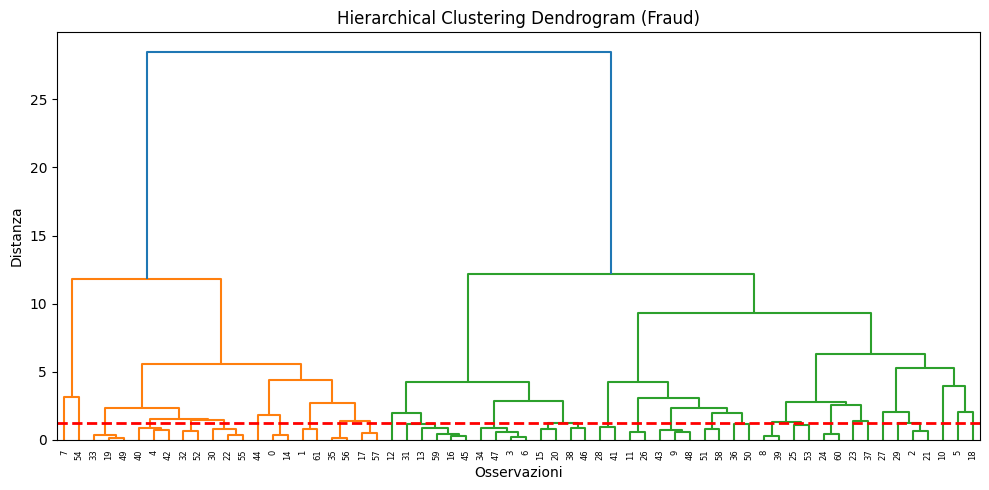

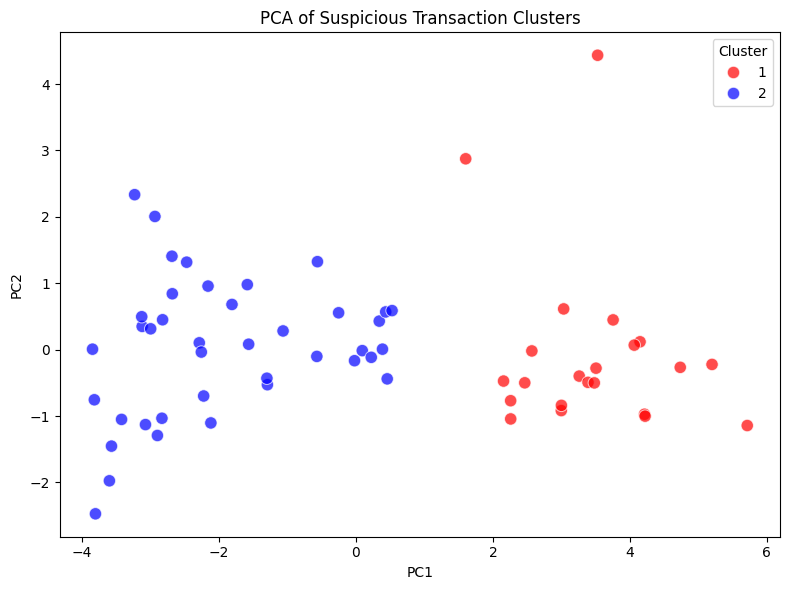

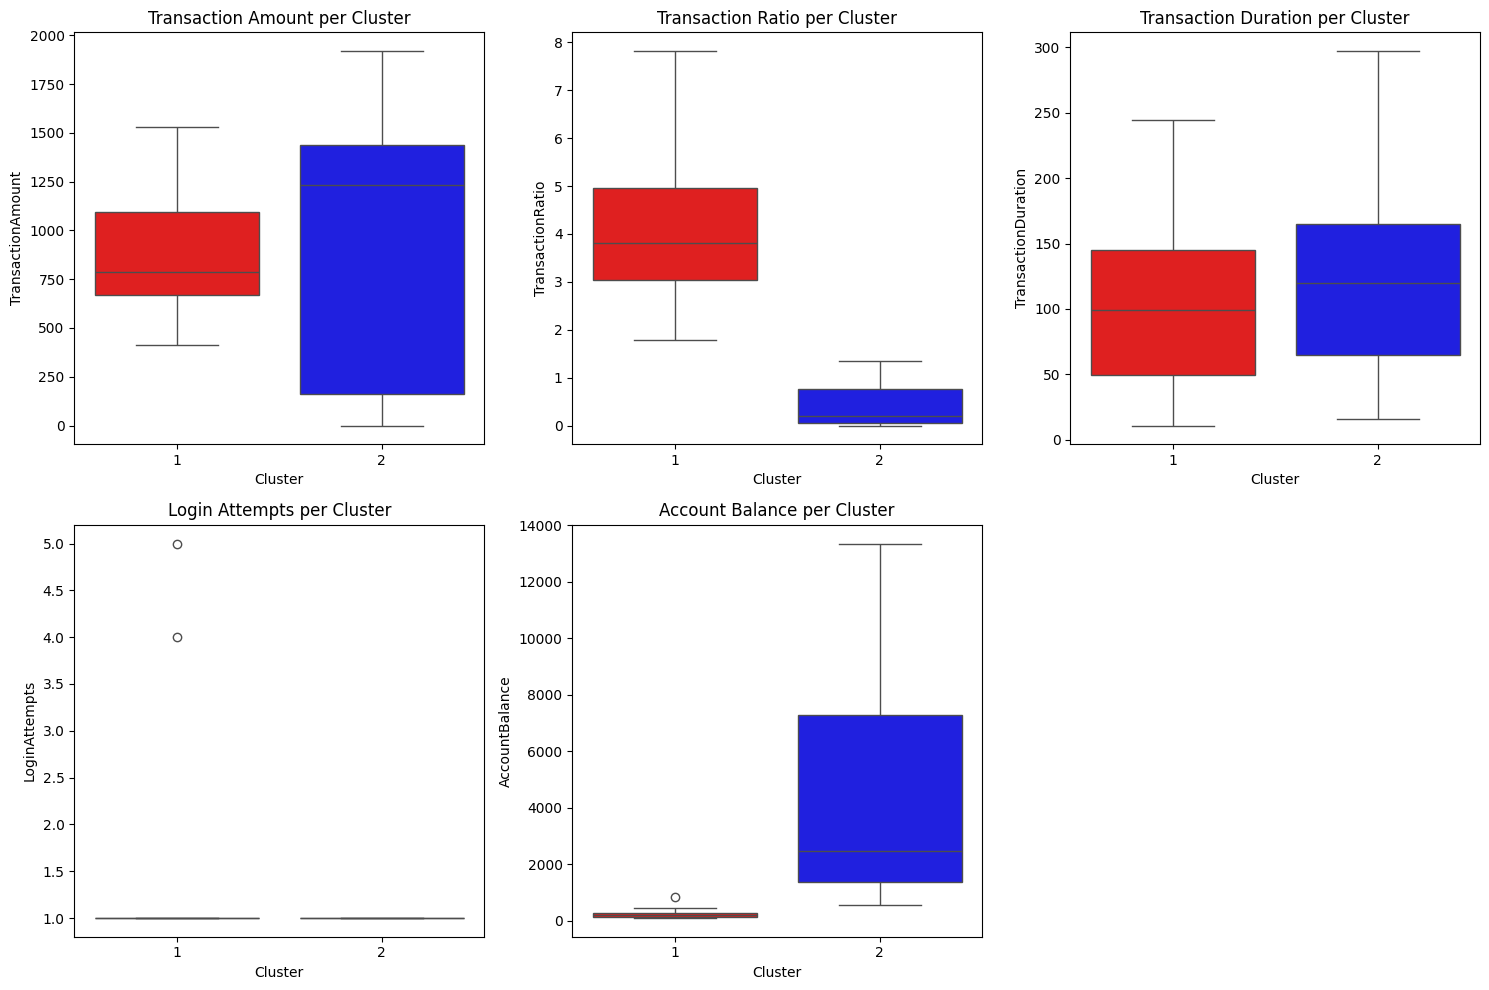

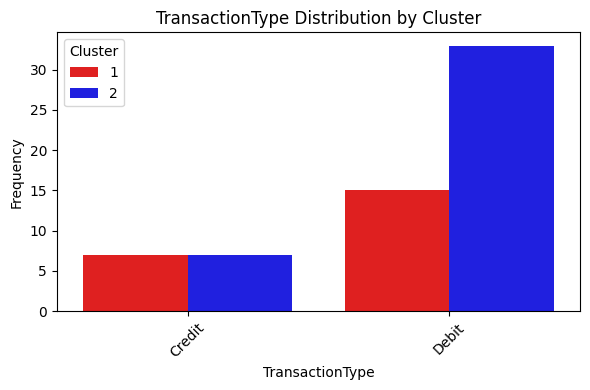

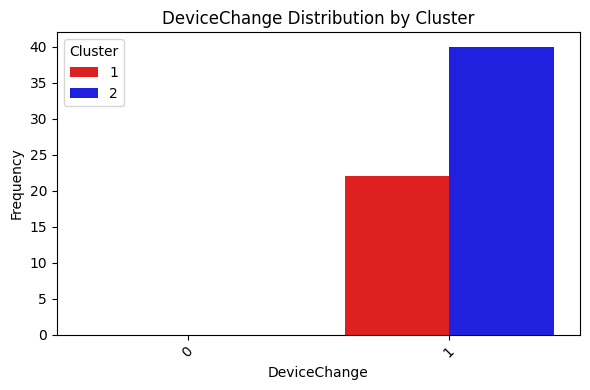

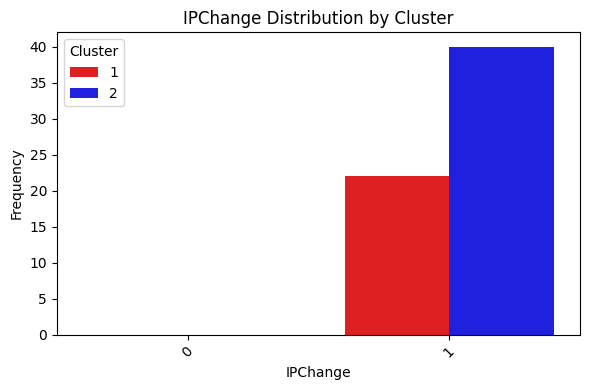

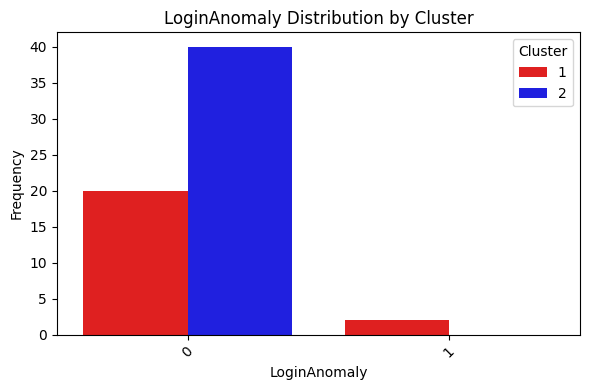

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA

# --------------------------
# Hierarchical Clustering on Suspicious Transactions
# --------------------------
# Filtriamo le osservazioni sospette. In R venivano eliminate le colonne 6 e 7;
# qui assumiamo che siano quelle relative a "StandardizedIPChange" e "StandardizedDaysSinceLastTransaction"
columns_to_drop = ['StandardizedIPChange', 'StandardizedDaysSinceLastTransaction']
outlier_data = final_data[final_data['PotentialFraud'] == 1].drop(columns=columns_to_drop, errors='ignore')

# Calcolo della matrice di distanza (Euclidea)
dist_matrix = pdist(outlier_data, metric='euclidean')

# Clustering gerarchico con il metodo Ward (equivalente a ward.D2)
hc = linkage(dist_matrix, method='ward')

# Plot del dendrogramma
plt.figure(figsize=(10, 5))
dendrogram(hc)
plt.title("Hierarchical Clustering Dendrogram (Suspicious Transactions)")
plt.xlabel("Osservazioni")
plt.ylabel("Distanza")
plt.tight_layout()
plt.show()

# Creazione dei cluster: ad es. k = 2 (puoi modificarlo)
k = 2
outlier_clusters = fcluster(hc, t=k, criterion='maxclust')

# Plot del dendrogramma con una linea orizzontale per evidenziare il taglio
plt.figure(figsize=(10, 5))
dendrogram(hc)
plt.title("Hierarchical Clustering Dendrogram (Fraud)")
plt.xlabel("Osservazioni")
plt.ylabel("Distanza")
# Nota: in Python non esiste una funzione diretta come rect.hclust di R,
# ma possiamo disegnare una linea orizzontale per indicare la soglia (qui esemplificata)
threshold = np.median(hc[:, 2])
plt.axhline(y=threshold, color='red', linestyle='dashed', lw=2)
plt.tight_layout()
plt.show()

# --------------------------
# PCA sui Transazioni Sospette
# --------------------------
# Applichiamo la PCA sui dati sospetti (outlier_data)
pca_outliers = PCA(n_components=2)
pca_scores = pca_outliers.fit_transform(outlier_data)

# Creiamo un DataFrame con i punteggi delle prime due componenti e l'assegnazione ai cluster
pca_df = pd.DataFrame({
    'PC1': pca_scores[:, 0],
    'PC2': pca_scores[:, 1],
    'Cluster': outlier_clusters.astype(str),  # trasformiamo in stringa per visualizzazione
    'Observation': outlier_data.index
})

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster',
                palette={'1': 'red', '2': 'blue'}, s=80, alpha=0.7)
plt.title("PCA of Suspicious Transaction Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# --------------------------
# Cluster Comparison of Suspicious Transactions
# --------------------------
# Aggiungiamo la colonna Cluster a outlier_data
outlier_data = outlier_data.copy()
outlier_data['Cluster'] = outlier_clusters.astype(str)

# Creiamo un DataFrame di confronto: usiamo gli indici (outlier_data.index) per estrarre
# variabili originali dal DataFrame bank
comparison_df = pd.DataFrame({
    'Cluster': outlier_data['Cluster'],
    'TransactionAmount': bank.loc[outlier_data.index, 'TransactionAmount'],
    'TransactionRatio': bank.loc[outlier_data.index, 'TransactionRatio'],
    'TransactionDuration': bank.loc[outlier_data.index, 'TransactionDuration'],
    'LoginAttempts': bank.loc[outlier_data.index, 'LoginAttempts'],
    'AccountBalance': bank.loc[outlier_data.index, 'AccountBalance']
})

# Creiamo i boxplot per confrontare le caratteristiche dei cluster
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

sns.boxplot(data=comparison_df, x='Cluster', y='TransactionAmount',
            palette={'1': 'red', '2': 'blue'}, ax=axs[0,0])
axs[0,0].set_title("Transaction Amount per Cluster")

sns.boxplot(data=comparison_df, x='Cluster', y='TransactionRatio',
            palette={'1': 'red', '2': 'blue'}, ax=axs[0,1])
axs[0,1].set_title("Transaction Ratio per Cluster")

sns.boxplot(data=comparison_df, x='Cluster', y='TransactionDuration',
            palette={'1': 'red', '2': 'blue'}, ax=axs[0,2])
axs[0,2].set_title("Transaction Duration per Cluster")

sns.boxplot(data=comparison_df, x='Cluster', y='LoginAttempts',
            palette={'1': 'red', '2': 'blue'}, ax=axs[1,0])
axs[1,0].set_title("Login Attempts per Cluster")

sns.boxplot(data=comparison_df, x='Cluster', y='AccountBalance',
            palette={'1': 'red', '2': 'blue'}, ax=axs[1,1])
axs[1,1].set_title("Account Balance per Cluster")

# Rimuoviamo l'ultimo subplot vuoto
fig.delaxes(axs[1,2])
plt.tight_layout()
plt.show()

# --------------------------
# Analisi delle Variabili Categoriali
# --------------------------
# Selezioniamo le variabili categoriali di interesse
selected_vars = ["TransactionType", "DeviceChange", "IPChange", "LoginAnomaly"]

# Estraiamo le osservazioni sospette dal DataFrame bank usando gli indici di outlier_data
cluster_cat = bank.loc[outlier_data.index, selected_vars].copy()
cluster_cat['Cluster'] = outlier_data['Cluster']

# Per ciascuna variabile, creiamo un grafico a barre per visualizzare la distribuzione per cluster
for var in selected_vars:
    freq_df = cluster_cat.groupby(['Cluster', var]).size().reset_index(name='Count')
    plt.figure(figsize=(6,4))
    sns.barplot(data=freq_df, x=var, y='Count', hue='Cluster',
                palette={'1': 'red', '2': 'blue'})
    plt.title(f"{var} Distribution by Cluster")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
